In [1]:
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

#sci-kit learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#text/NLP 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.metrics import (confusion_matrix,accuracy_score, roc_auc_score, recall_score,
    precision_score, roc_curve, auc)
from sklearn.metrics import ConfusionMatrixDisplay


#for oversampling 
from imblearn.over_sampling import RandomOverSampler

In [2]:
df_lyrics = pd.read_csv('lyrics_all_combined.csv')
df_lyrics.head(3)

df_lyrics=df_lyrics.dropna(subset=['lyrics'])


In [3]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8025 entries, 0 to 8024
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   8025 non-null   object
 1   track_name    8025 non-null   object
 2   lyrics        8025 non-null   object
 3   release_date  8025 non-null   int64 
 4   genre         8025 non-null   object
dtypes: int64(1), object(4)
memory usage: 376.2+ KB


In [4]:
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

df_lyrics['lyrics'] = df_lyrics['lyrics'].apply(str)

# Convert all string of lyrics to lowercase.
df_lyrics['lyrics'] = df_lyrics['lyrics'].str.lower()

# Tokenize text from lyrics. 
df_lyrics['tokenized'] = df_lyrics['lyrics'].apply(word_tokenize)

# Remove punctuations.
punc_marks = list(string.punctuation)
df_lyrics['tokenized'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in punc_marks])
                                                                       
# Display smaple data. 
df_lyrics.sample(10)

,artist_name,track_name,lyrics,release_date,genre,tokenized
1057,morphine,mary,cross finger knock pray cross cannonball write...,2000,blues,"[cross, finger, knock, pray, cross, cannonball..."
7517,kutless,strong tower,wander desert long home dream go astray strand...,2005,rock,"[wander, desert, long, home, dream, go, astray..."
5116,hirie,i wanna be,wanna wanna tell wrong tell right tell butterf...,2015,reggae,"[wan, na, wan, na, tell, wrong, tell, right, t..."
6651,judas priest,some heads are gonna roll,look leave look right live danger tonight enem...,1984,rock,"[look, leave, look, right, live, danger, tonig..."
912,santana,changes,feel change acoming time break wall silence li...,1981,blues,"[feel, change, acoming, time, break, wall, sil..."
6577,quiet riot,love's a bitch,know runnin know give crack lie breath time mi...,1983,rock,"[know, runnin, know, give, crack, lie, breath,..."
3175,lucinda williams,six blocks away,sleep second street roof head food hardly caus...,1992,country,"[sleep, second, street, roof, head, food, hard..."
3243,molly hatchet,both sides,ridin streetcar name desire fate seal comin li...,1983,country,"[ridin, streetcar, name, desire, fate, seal, c..."
5166,clinton fearon,stop the hate,stop hate stop hate stop hate stop hate brothe...,2004,reggae,"[stop, hate, stop, hate, stop, hate, stop, hat..."
3772,robert earl keen,sing one for sister,summer sunday even home place play guitar sist...,1989,country,"[summer, sunday, even, home, place, play, guit..."


In [5]:
stopwords = nltk.corpus.stopwords.words('english')

# Add personalised list of stop words.
stopwords.extend(["'m", "'s", "'d", "hi", "im", "wa", "n't",'wan','na','u','gon' ,'ahah','ayo',"'get", "'ll", "'re", "'ve", "get", "still", "mmm", "ooh", "oooh", "yah", "yeh","mmm", "hmm","i'm"])

# Remove the stop words from the dataset. 
df_lyrics['cleaned_stopwords'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

# Check first few rows. 
df_lyrics.head(3)

,artist_name,track_name,lyrics,release_date,genre,tokenized,cleaned_stopwords
0,jd mcpherson,i can't complain,heart gang little catch couple fish water swis...,2011,blues,"[heart, gang, little, catch, couple, fish, wat...","[heart, gang, little, catch, couple, fish, wat..."
1,the marshall tucker band,change is gonna come,time dream money fear grow time come think lea...,1978,blues,"[time, dream, money, fear, grow, time, come, t...","[time, dream, money, fear, grow, time, come, t..."
2,dinah washington,blue gardenia,blue gardenia blue toss aside like gardenia ne...,1955,blues,"[blue, gardenia, blue, toss, aside, like, gard...","[blue, gardenia, blue, toss, aside, like, gard..."


In [6]:
def determine_wordnet_speech(word_tag):
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Add part of speech tags.
df_lyrics['pos_tags'] = df_lyrics['cleaned_stopwords'].apply(nltk.tag.pos_tag)

# Function to get part of speech in WordNet format.
df_lyrics['pos_tags'] = df_lyrics['pos_tags'].apply(lambda x: [(word, determine_wordnet_speech(pos_tag)) for (word, pos_tag) in x])

word_lemmatizer = WordNetLemmatizer()
df_lyrics['lyrics_lemmatized'] = df_lyrics['pos_tags'].apply(lambda x: [word_lemmatizer.lemmatize(word, tag) for word, tag in x])

# Convert list to string datatype. 
df_lyrics['lyrics_lemmatized'] = [' '.join(map(str,l)) for l in df_lyrics['lyrics_lemmatized']]

# Check few rows.
df_lyrics.head(3)

,artist_name,track_name,lyrics,release_date,genre,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized
0,jd mcpherson,i can't complain,heart gang little catch couple fish water swis...,2011,blues,"[heart, gang, little, catch, couple, fish, wat...","[heart, gang, little, catch, couple, fish, wat...","[(heart, n), (gang, n), (little, a), (catch, a...",heart gang little catch couple fish water swis...
1,the marshall tucker band,change is gonna come,time dream money fear grow time come think lea...,1978,blues,"[time, dream, money, fear, grow, time, come, t...","[time, dream, money, fear, grow, time, come, t...","[(time, n), (dream, n), (money, n), (fear, n),...",time dream money fear grow time come think lea...
2,dinah washington,blue gardenia,blue gardenia blue toss aside like gardenia ne...,1955,blues,"[blue, gardenia, blue, toss, aside, like, gard...","[blue, gardenia, blue, toss, aside, like, gard...","[(blue, a), (gardenia, n), (blue, n), (toss, n...",blue gardenia blue toss aside like gardenia ne...


In [7]:
df_lyrics.to_csv('lyrics_processed.csv')
df_lyrics['lyrics']=df_lyrics['lyrics_lemmatized']

In [8]:
df_lyrics.head()

,artist_name,track_name,lyrics,release_date,genre,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized
0,jd mcpherson,i can't complain,heart gang little catch couple fish water swis...,2011,blues,"[heart, gang, little, catch, couple, fish, wat...","[heart, gang, little, catch, couple, fish, wat...","[(heart, n), (gang, n), (little, a), (catch, a...",heart gang little catch couple fish water swis...
1,the marshall tucker band,change is gonna come,time dream money fear grow time come think lea...,1978,blues,"[time, dream, money, fear, grow, time, come, t...","[time, dream, money, fear, grow, time, come, t...","[(time, n), (dream, n), (money, n), (fear, n),...",time dream money fear grow time come think lea...
2,dinah washington,blue gardenia,blue gardenia blue toss aside like gardenia ne...,1955,blues,"[blue, gardenia, blue, toss, aside, like, gard...","[blue, gardenia, blue, toss, aside, like, gard...","[(blue, a), (gardenia, n), (blue, n), (toss, n...",blue gardenia blue toss aside like gardenia ne...
3,jimi hendrix,burning of the midnight lamp,morning dead leave lead moon loneliness felt t...,1968,blues,"[morning, dead, leave, lead, moon, loneliness,...","[morning, dead, leave, lead, moon, loneliness,...","[(morning, n), (dead, a), (leave, v), (lead, a...",morning dead leave lead moon loneliness felt t...
4,graveyard,ungrateful are the dead,bury darkness free thought happiness reach usu...,2011,blues,"[bury, darkness, free, thoughts, happiness, re...","[bury, darkness, free, thoughts, happiness, re...","[(bury, n), (darkness, n), (free, a), (thought...",bury darkness free thought happiness reach usu...


In [9]:
#print(df_lyrics[df_lyrics['genre']=='Alternative Rock'])
#df_lyrics['genre'] = df_lyrics['genre'].replace(['Alternative Rock'],'alt_rock')


In [10]:
X = df_lyrics['lyrics']
y = df_lyrics['genre']

In [11]:
X.head()

0    heart gang little catch couple fish water swis...
1    time dream money fear grow time come think lea...
2    blue gardenia blue toss aside like gardenia ne...
3    morning dead leave lead moon loneliness felt t...
4    bury darkness free thought happiness reach usu...
Name: lyrics, dtype: object

In [12]:
y.unique()

array(['blues', 'country', 'reggae', 'rock'], dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [14]:
y_train.value_counts(normalize=True)

country    0.252648
reggae     0.249221
rock       0.249221
blues      0.248910
Name: genre, dtype: float64

In [15]:
def get_metrics(model_name, model, X, y, over=False):
    #create labels and empty df
    labels = ['blues', 'rock', 'country', 'reggae']
    #set up model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    #if oversampling is False, fit on regular X_train, y_train splot
    if over==False:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        train_score = model.score(X_train,y_train)
    #if oversampling is True, use RandomOverSample to balance classes for training data
    elif over==True:
        oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_over, y_over = oversample.fit_resample(pd.DataFrame(X_train), y_train)
        X_over = X_over.squeeze()
        model.fit(X_over,y_over)
        preds = model.predict(X_test)
        train_score = model.score(X_over, y_over)
    #store results
    data = confusion_matrix(y_test, preds)
    results = {labels[i] : data[i][i]/sum(data[i]) for i in range(0, len(data))}
    result_df = pd.DataFrame(results, index=[0])
    result_df['model'] = model_name
    result_df['oversampling'] = over
    result_df['train_accuracy'] = train_score
    result_df['accuracy'] = model.score(X_test,y_test)
    return result_df[['model','oversampling','train_accuracy','accuracy'] + labels]

In [16]:
pipe_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

#fit
pipe_cv_rfc.fit(X_train,y_train)
pipe_cv_rfc.score(X_train, y_train), pipe_cv_rfc.score(X_test,y_test)

(0.9998442367601246, 0.5177570093457944)

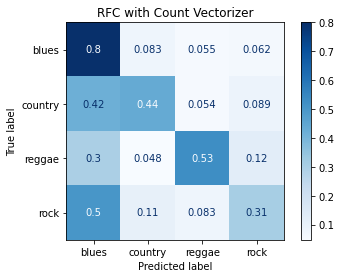

In [17]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with Count Vectorizer");

In [18]:
pipe_tfv_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

#fit
pipe_tfv_rfc.fit(X_train,y_train)
pipe_tfv_rfc.score(X_train, y_train), pipe_tfv_rfc.score(X_test,y_test)

(0.9998442367601246, 0.5383177570093458)

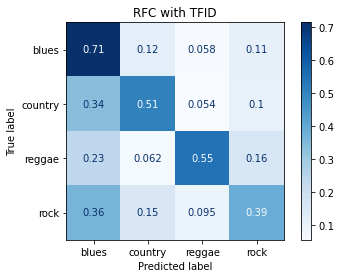

In [19]:
ConfusionMatrixDisplay.from_estimator(pipe_tfv_rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("RFC with TFID");

In [20]:
pipe_cv_svm = Pipeline([
    ('cv',CountVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_cv_svm.fit(X_train,y_train)
pipe_cv_svm.score(X_train,y_train), pipe_cv_svm.score(X_test,y_test)

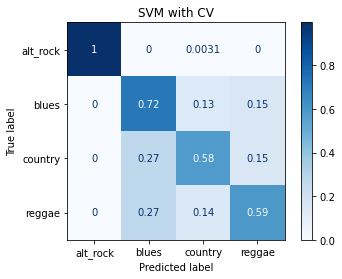

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_svm, X_test, y_test, cmap="Blues", normalize='true')
plt.title("SVM with CV");

In [ ]:
pipe_tfv_svm = Pipeline([
    ('cv',TfidfVectorizer()),
    ('svm', svm.SVC(C=1.0, kernel='linear', random_state=42))]
)

pipe_tfv_svm.fit(X_train,y_train)
pipe_tfv_svm.score(X_train,y_train), pipe_tfv_svm.score(X_test,y_test)

(0.886758439855785, 0.7123197903014417)

In [ ]:
pipe_cv_dtc = Pipeline([
    ('cv',CountVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_cv_dtc.fit(X_train,y_train)
pipe_cv_dtc.score(X_train,y_train), pipe_cv_dtc.score(X_test,y_test)

(1.0, 0.59043250327654)

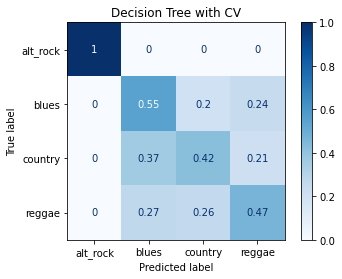

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_cv_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with CV");

In [ ]:
pipe_tfid_dtc = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('dtc', DecisionTreeClassifier(random_state=42))]
)

pipe_tfid_dtc.fit(X_train,y_train)
pipe_tfid_dtc.score(X_train,y_train), pipe_tfid_dtc.score(X_test,y_test)

(1.0, 0.5923984272608126)

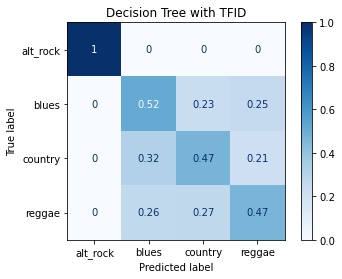

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_tfid_dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree with TFID");